# Project 4 

## Problem Statement

## Executive Summary

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyreadr
import seaborn as sns

import myfunctions as f

import io

%matplotlib inline

### Data Import

In [2]:

df_train = pd.read_csv('../datasets/train.csv')
df_test = pd.read_csv('../datasets/test.csv')
df_spray = pd.read_csv('../datasets/spray.csv')
df_weather = pd.read_csv('../datasets/weather.csv')

## EDA

In [3]:
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [4]:
df_weather.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

In [5]:
df_train.columns = df_train.columns.str.lower()

In [6]:
df_spray = df_spray.loc[df_spray['Longitude'] > -88]

In [7]:
#df_spray['Date'] = pd.to_datetime(df_spray['Date'])

In [8]:
#test = df_train.loc[df_train['date'].str.contains('2013')]
#spraytest = df_spray.loc[df_spray['date'].str.contains('2013')]
#test

In [9]:
#date2013 = [row for row in test['Date']]
#date2013.extend([row for row in spraytest['Date']])
#date2013 = list(dict.fromkeys(date2013))
from datetime import datetime    
#date2013.sort(key=lambda date: datetime.strptime(date, "%Y-%m-%d"))


#date2013

In [10]:
#date2013 = ['2013-06-07','2013-09-26']

In [11]:
df_train['species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: species, dtype: int64

In [12]:
pd.pivot_table(df_train, index='species', values='wnvpresent')

,wnvpresent
species,
CULEX ERRATICUS,0.000000
CULEX PIPIENS,0.088922
CULEX PIPIENS/RESTUANS,0.055135
CULEX RESTUANS,0.017883
CULEX SALINARIUS,0.000000
CULEX TARSALIS,0.000000
CULEX TERRITANS,0.000000


In [13]:
top10 = df_train.groupby('trap')['wnvpresent','nummosquitos'].mean().sort_values(by='wnvpresent',ascending=False)
top10.head(10)

,wnvpresent,nummosquitos
trap,,
T143,0.193548,7.419355
T006,0.166667,4.458333
T005,0.142857,3.571429
T233,0.140000,15.160000
T014,0.133333,12.133333
T096,0.120000,11.560000
T003,0.114754,11.032787
T015,0.114286,4.828571
T235,0.112903,8.983871


(array([5585., 1411.,  697.,  492.,  317.,  259.,  196.,  220.,  159.,
        1170.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <a list of 10 Patch objects>)

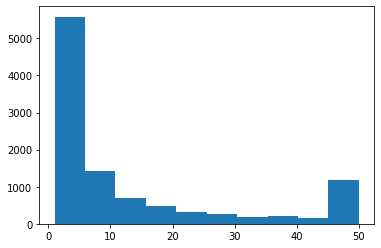

In [14]:
plt.hist(data=df_train,x='nummosquitos')

In [15]:
#spray2013.groupby(['Date']).mean()

In [16]:
#for i in date2013:
#    nownv2013 = df_train.loc[(df_train['Date'] == i) & (df_train['WnvPresent'] == 0)]
#    wnv2013 = df_train.loc[(df_train['Date'] == i) & (df_train['WnvPresent'] == 1)]
#    if i == '2013-06-07':
#        spraying = spray2013.loc[spray2013['Date'] == i]
#    else:
#        spraying = spraying.append(spray2013.loc[spray2013['Date'] == i])
#    f.gen_map()
#    locations = nownv2013[['Longitude', 'Latitude']].drop_duplicates().values
#    locations1 = wnv2013[['Longitude', 'Latitude']].drop_duplicates().values
#    locations2 = spraying[['Longitude', 'Latitude']].drop_duplicates().values
#    plt.scatter(locations2[:,0], locations2[:,1], marker='o', c='g')
#    plt.scatter(locations[:,0], locations[:,1], marker='x', c='b')
#    plt.scatter(locations1[:,0], locations1[:,1], marker='x', c='r')
#    plt.title(i)
#    plt.pause(0.05)

#plt.show()

In [17]:
df_spray.columns

Index(['Date', 'Time', 'Latitude', 'Longitude'], dtype='object')

In [18]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [19]:
df_train.dtypes

date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
nummosquitos                       int64
wnvpresent                         int64
dtype: object

In [20]:
df_weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [21]:
# Roshan's weather cleaning
def update_cols(data):
    data = data.replace('M', np.nan)
    data = data.replace('-', np.nan)
    data = data.replace(' ', np.nan)
    data = data.replace('  T', '0.05')
    return data

df_weather.columns = df_weather.columns.str.lower()
df_weather = update_cols(df_weather)

def mirror_columns(columns):
    df_weather[columns] = df_weather.apply(lambda x: df_weather.iloc[::2][columns].values.repeat(2))
    
# Fill in the missing data from station 2 by mirroring station 1
mirror_columns('depart')
mirror_columns('sunrise')
mirror_columns('sunset')
mirror_columns('depth')
mirror_columns('snowfall')

# Drop water1 column as its missing all the data
df_weather.drop(['water1'], axis = 1, inplace= True)
# Fiil up blank cells in codesum with 'MODERATE'
df_weather['codesum'] = df_weather['codesum'].replace(np.nan, 'MODERATE')
# Fill null values with column median
def fill_null(columns):
    df_weather[columns] = df_weather[columns].fillna(df_weather[columns].median())
    
fill_null('preciptotal')
fill_null('avgspeed')
fill_null('wetbulb')
fill_null('stnpressure')
fill_null('sealevel')
fill_null('heat')
fill_null('cool')

# Fill null values of Tavg column with the average of Tmax and Tmin columns (Tmax + Tmin)/2
df_weather['tavg'] = df_weather.apply(lambda row: (row['tmax'] + row['tmin']) * 0.5
                                      if pd.isnull(row['tavg']) else row['tavg'], axis=1)

def change_dtype_flt(columns):
    df_weather[columns] = df_weather[columns].astype(float)
    
# Amend the column data type to float
change_dtype_flt('preciptotal')
change_dtype_flt('stnpressure')
change_dtype_flt('sealevel')
change_dtype_flt('avgspeed')
change_dtype_flt('preciptotal')
change_dtype_flt('tavg')
change_dtype_flt('snowfall')

def change_dtype_int(columns):
    df_weather[columns] = df_weather[columns].astype(int)

# Amend the column data type to string
change_dtype_int('depart')
change_dtype_int('wetbulb')
change_dtype_int('heat')
change_dtype_int('cool')
change_dtype_int('sunrise')
change_dtype_int('sunset')
change_dtype_int('depth')

# Convert object to datetime and create individual columns for year, month and day
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_weather['year'] = df_weather['date'].dt.year
df_weather['month'] = df_weather['date'].dt.month
df_weather['day'] = df_weather['date'].dt.day

# Allows to identify days with volatile weather
df_weather['trange'] = df_weather['tmax'] - df_weather['tmin']

In [22]:
df_weather.isnull().sum().sort_values(ascending=False)

trange         0
sunset         0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
codesum        0
day            0
depth          0
snowfall       0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
year           0
month          0
station        0
dtype: int64

In [23]:
df_weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                  float64
depart                  int32
dewpoint                int64
wetbulb                 int32
heat                    int32
cool                    int32
sunrise                 int32
sunset                  int32
codesum                object
depth                   int32
snowfall              float64
preciptotal           float64
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir               int64
avgspeed              float64
year                    int64
month                   int64
day                     int64
trange                  int64
dtype: object

In [24]:
df_weather[['tavg']].isnull().sum()

tavg    0
dtype: int64

In [25]:
df = pd.merge(df_train, df_weather, on="date")

In [26]:
df[['date', 'nummosquitos', 'species', 'tavg', 'wnvpresent', 'sealevel', 'dewpoint', 'wetbulb', 'preciptotal', 'stnpressure']].isnull().sum()

date            0
nummosquitos    0
species         0
tavg            0
wnvpresent      0
sealevel        0
dewpoint        0
wetbulb         0
preciptotal     0
stnpressure     0
dtype: int64

In [27]:
df = df[['date', 'nummosquitos', 'species', 'tavg', 'wnvpresent', 'sealevel', 'dewpoint', 'wetbulb', 'preciptotal', 'stnpressure']]

In [28]:
df.dtypes

date            datetime64[ns]
nummosquitos             int64
species                 object
tavg                   float64
wnvpresent               int64
sealevel               float64
dewpoint                 int64
wetbulb                  int32
preciptotal            float64
stnpressure            float64
dtype: object

In [29]:
df_mean = df.groupby(['date']).mean()

In [30]:
df_mean.tail()

,nummosquitos,tavg,wnvpresent,sealevel,dewpoint,wetbulb,preciptotal,stnpressure
date,,,,,,,,
2013-08-29,18.496503,78.0,0.265734,30.005,64.5,69.0,0.000,29.325
2013-09-06,17.552448,73.0,0.223776,30.110,56.5,63.5,0.000,29.410
2013-09-12,15.899281,72.5,0.165468,29.975,58.5,64.0,0.055,29.310
2013-09-19,9.196429,77.0,0.098214,29.870,67.0,69.5,0.445,29.175
2013-09-26,5.489130,64.0,0.043478,30.040,52.0,58.0,0.000,29.370


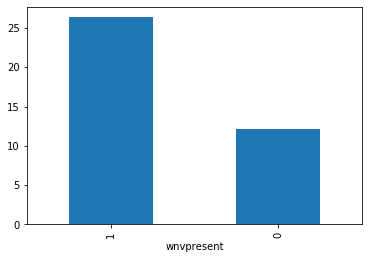

In [31]:
df_train.groupby('wnvpresent')['nummosquitos'].mean().sort_values(ascending=False).plot.bar();

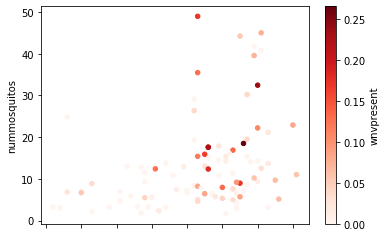

In [32]:
ax = df_mean.plot.scatter(x='tavg', y='nummosquitos', c='wnvpresent', colormap='Reds');
# Higher temperature = More mosquitoes = potentially more WNV

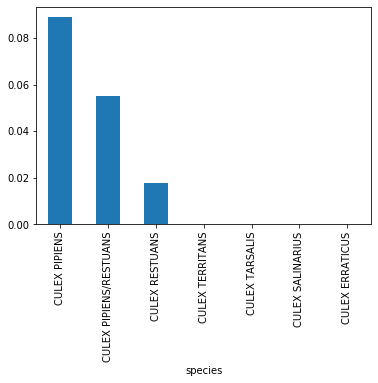

In [33]:
df_train.groupby('species')['wnvpresent'].mean().sort_values(ascending=False).plot.bar();

In [34]:
df['wnvspecies'] = [1 if ('PIPIENS' or 'RESTUANS') in row else 0 for row in df['species']]
df['wnvspecies'].value_counts(normalize=True)


1    0.709214
0    0.290786
Name: wnvspecies, dtype: float64

In [35]:
df['3cat'] = df['wnvspecies'] + df['wnvpresent']

In [36]:
df.groupby('wnvspecies')['tavg'].mean().sort_values(ascending=False)

wnvspecies
1    73.354986
0    72.211457
Name: tavg, dtype: float64

In [37]:
df['3cat'].value_counts(normalize=True)

1    0.666096
0    0.286122
2    0.047782
Name: 3cat, dtype: float64

In [38]:
df_test.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')

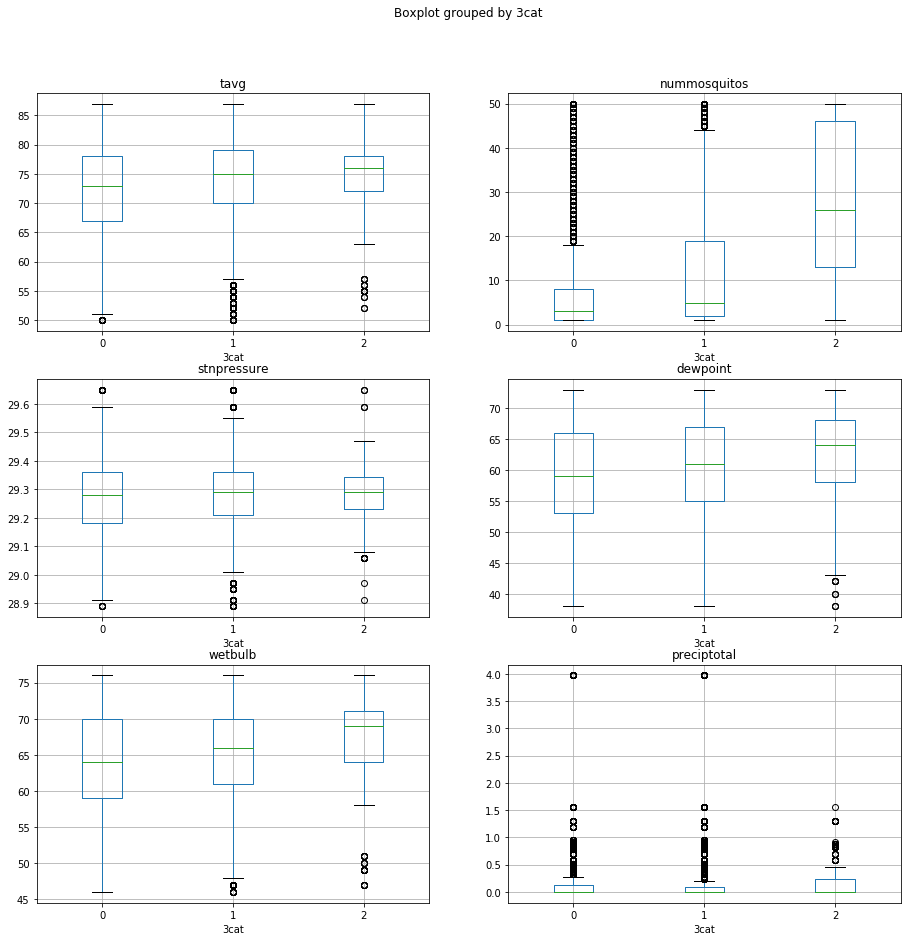

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,15)) 

df.boxplot(column='tavg', by='3cat', ax=axes[0,0]) 
df.boxplot(column='nummosquitos', by='3cat', ax=axes[0,1]) 
df.boxplot(column='stnpressure', by='3cat', ax=axes[1,0]) 
df.boxplot(column='dewpoint', by='3cat', ax=axes[1,1]) 
df.boxplot(column='wetbulb', by='3cat', ax=axes[2,0]) 
df.boxplot(column='preciptotal', by='3cat', ax=axes[2,1]) 

# etc.

plt.show()
# Need to check other weather data such as Wetbulb, after string imputation is complete
# More mosquitoes (Cullex Pipiens) potentially due to stagnant water areas which results in more breeding
# https://www.isglobal.org/en/healthisglobal/-/custom-blog-portlet/el-mosquito-comun-un-companero-indeseable-en-nuestras-vidas/5083982/8301

In [40]:
df.head()

,date,nummosquitos,species,tavg,wnvpresent,sealevel,dewpoint,wetbulb,preciptotal,stnpressure,wnvspecies,3cat
0,2007-05-29,1,CULEX PIPIENS/RESTUANS,74.0,0,30.11,58,65,0.0,29.39,1,1
1,2007-05-29,1,CULEX PIPIENS/RESTUANS,77.0,0,30.09,59,66,0.0,29.44,1,1
2,2007-05-29,1,CULEX RESTUANS,74.0,0,30.11,58,65,0.0,29.39,0,0
3,2007-05-29,1,CULEX RESTUANS,77.0,0,30.09,59,66,0.0,29.44,0,0
4,2007-05-29,1,CULEX RESTUANS,74.0,0,30.11,58,65,0.0,29.39,0,0


In [41]:
df_date = df.groupby('date')['nummosquitos','wnvpresent'].sum()
df_temp = df.groupby('date')['tavg','wetbulb'].mean()
df_date['tavg'] = df_temp['tavg']
df_date['wetbulb'] = df_temp['wetbulb']
df_date.head()

,nummosquitos,wnvpresent,tavg,wetbulb
date,,,,
2007-05-29,80,0,75.5,65.5
2007-06-05,254,0,56.5,51.5
2007-06-26,432,0,81.5,72.0
2007-06-29,170,0,63.5,59.5
2007-07-02,480,0,67.0,58.5


In [42]:
df_date_month = df_date.groupby(by=[df_date.index.month])['nummosquitos','wnvpresent'].sum()
df_temp_month = df_date.groupby(by=[df_date.index.month])['tavg','wetbulb'].mean()
df_date_month['tavg'] = df_temp_month['tavg']
df_date_month['wetbulb'] = df_temp_month['wetbulb']

In [43]:
df_date_month

,nummosquitos,wnvpresent,tavg,wetbulb
date,,,,
5,460,0,67.250000,59.750000
6,33156,2,68.452381,60.595238
7,74496,92,74.595238,65.761905
8,116072,754,75.134615,67.403846
9,42058,250,70.636364,62.409091
10,3836,4,61.000000,54.500000


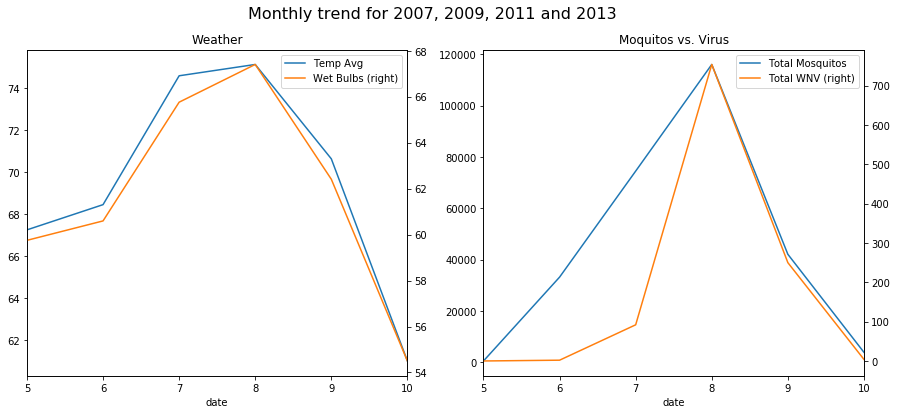

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))

fig.suptitle("Monthly trend for 2007, 2009, 2011 and 2013", fontsize=16)
df_date_month.tavg.plot(label="Temp Avg", legend=True, ax=axes[0])
df_date_month.wetbulb.plot(secondary_y=True, label="Wet Bulbs", legend=True, ax=axes[0])
axes[0].set_title('Weather')

df_date_month.nummosquitos.plot(label='Total Mosquitos', legend=True,  ax=axes[1]) 
df_date_month.wnvpresent.plot(label='Total WNV', legend=True, ax=axes[1], secondary_y=True)
axes[1].set_title('Moquitos vs. Virus')

plt.show()

In [45]:
df_weather_date = df_weather.groupby('date')['tavg','wetbulb', 'preciptotal', 'stnpressure'].mean()
df_weather_year = df_weather_date.groupby(by=[df_weather_date.index.year])['tavg','wetbulb', 'preciptotal', 'stnpressure'].mean()
df_weather_year

,tavg,wetbulb,preciptotal,stnpressure
date,,,,
2007,69.177989,60.584239,0.113179,29.317962
2008,66.024457,58.546196,0.159755,29.296712
2009,64.364130,57.301630,0.135245,29.282500
2010,68.687500,60.573370,0.158832,29.270761
2011,67.023098,59.663043,0.149022,29.252065
2012,69.092391,59.559783,0.095625,29.271984
2013,66.974185,59.423913,0.115299,29.297717
2014,66.570652,58.853261,0.166168,29.285679


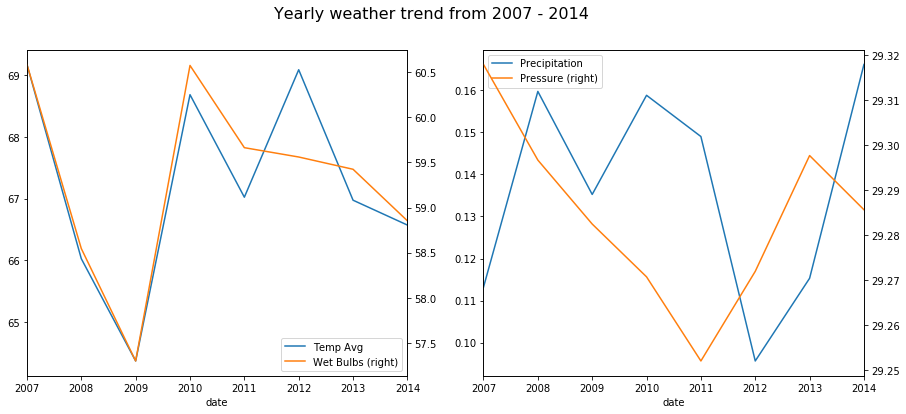

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))

fig.suptitle("Yearly weather trend from 2007 - 2014", fontsize=16)
df_weather_year.tavg.plot(label="Temp Avg", legend=True, ax=axes[0])
df_weather_year.wetbulb.plot(secondary_y=True, label="Wet Bulbs", legend=True, ax=axes[0])

df_weather_year.preciptotal.plot(label="Precipitation", legend=True, ax=axes[1])
df_weather_year.stnpressure.plot(secondary_y=True, label="Pressure", legend=True, ax=axes[1])
plt.show()

### Weather Data
---

In [47]:
import datetime as dt

In [48]:
df_weather.columns = df_weather.columns.str.lower()

In [49]:
df_weather.head()

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day,trange
0,1,2007-05-01,83,50,67.0,14,51,56,0,2,...,0.0,29.10,29.82,1.7,27,9.2,2007,5,1,33
1,2,2007-05-01,84,52,68.0,14,51,57,0,3,...,0.0,29.18,29.82,2.7,25,9.6,2007,5,1,32
2,1,2007-05-02,59,42,51.0,-3,42,47,14,0,...,0.0,29.38,30.09,13.0,4,13.4,2007,5,2,17
3,2,2007-05-02,60,43,52.0,-3,42,47,13,0,...,0.0,29.44,30.08,13.3,2,13.4,2007,5,2,17
4,1,2007-05-03,66,46,56.0,2,40,48,9,0,...,0.0,29.39,30.12,11.7,7,11.9,2007,5,3,20


In [50]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 25 columns):
station        2944 non-null int64
date           2944 non-null datetime64[ns]
tmax           2944 non-null int64
tmin           2944 non-null int64
tavg           2944 non-null float64
depart         2944 non-null int32
dewpoint       2944 non-null int64
wetbulb        2944 non-null int32
heat           2944 non-null int32
cool           2944 non-null int32
sunrise        2944 non-null int32
sunset         2944 non-null int32
codesum        2944 non-null object
depth          2944 non-null int32
snowfall       2944 non-null float64
preciptotal    2944 non-null float64
stnpressure    2944 non-null float64
sealevel       2944 non-null float64
resultspeed    2944 non-null float64
resultdir      2944 non-null int64
avgspeed       2944 non-null float64
year           2944 non-null int64
month          2944 non-null int64
day            2944 non-null int64
trange         2944 non-null 

In [51]:
# Replace M, blank spaces and '-' with Nan values, while T was replace with 0.05
# https://wgntv.com/weather/what-are-traces-of-precipitation/
def update_cols(df_weather):
    df_weather = df_weather.replace('M', np.nan)
    df_weather = df_weather.replace('-', np.nan)
    df_weather = df_weather.replace(' ', np.nan)
    df_weather = df_weather.replace('  T', '0.05')

    df_weather = update_cols(df_weather)

In [52]:
# Check for null
df_weather.isnull().sum().sort_values(ascending=False)

trange         0
sunset         0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
codesum        0
day            0
depth          0
snowfall       0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
year           0
month          0
station        0
dtype: int64

In [53]:
# Drop water1 column as its missing all the data
df_weather.drop(['water1'], axis = 1, inplace= True)

# Fiil up blank cells in codesum with 'MODERATE'
df_weather['codesum'] = df_weather['codesum'].replace(np.nan, 'MODERATE')

# Fill null values with column median
df_weather['preciptotal'] = df_weather['preciptotal'].fillna(df_weather['preciptotal'].median())
df_weather['avgspeed'] = df_weather['avgspeed'].fillna(df_weather['avgspeed'].median())
df_weather['wetbulb'] = df_weather['wetbulb'].fillna(df_weather['wetbulb'].median())
df_weather['stnpressure'] = df_weather['stnpressure'].fillna(df_weather['stnpressure'].median())
df_weather['sealevel'] = df_weather['sealevel'].fillna(df_weather['sealevel'].median())
df_weather['heat'] = df_weather['heat'].fillna(df_weather['heat'].median())
df_weather['cool'] = df_weather['cool'].fillna(df_weather['cool'].median())

# Fill null values of Tavg column with the average of Tmax and Tmin columns (Tmax + Tmin)/2
df_weather['tavg'] = df_weather.apply(lambda row: (row['tmax'] + row['tmin']) * 0.5
                                      if pd.isnull(row['tavg']) else row['tavg'], axis=1)

KeyError: "['water1'] not found in axis"

In [ ]:
def mirror_columns(columns):
    df_weather[columns] = df_weather.apply(lambda x: df_weather.iloc[::2][columns].values.repeat(2))
    
# Fill in the missing data from station 2 by mirroring station 1
mirror_columns('depart')
mirror_columns('sunrise')
mirror_columns('sunset')
mirror_columns('depth')
mirror_columns('snowfall')

In [ ]:
# Convert object to datetime and create individual columns for year, month and day
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_weather['year'] = df_weather['date'].dt.year
df_weather['month'] = df_weather['date'].dt.month
df_weather['day'] = df_weather['date'].dt.day

In [ ]:
def change_dtype_flt(columns):
    df_weather[columns] = df_weather[columns].astype(float)
    
# Amend the column data type to float
change_dtype_flt('preciptotal')
change_dtype_flt('stnpressure')
change_dtype_flt('sealevel')
change_dtype_flt('avgspeed')
change_dtype_flt('preciptotal')
change_dtype_flt('tavg')

def change_dtype_int(columns):
    df_weather[columns] = df_weather[columns].astype(int)

# Amend the column data type to integer
change_dtype_int('depart')
change_dtype_int('wetbulb')
change_dtype_int('heat')
change_dtype_int('cool')